In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

In [2]:
def morse(r, re, D, a):    
    return D*np.square(1-np.exp(-a*(r-re)))-D

def lennardJones(r, re, D):    
    return D*(np.power(re/r,12)-2*np.power(re/r,6))

LennardJones potential - depth D and distance re imply a spring constant k
Morse potential        - spring constant k can be selected independently


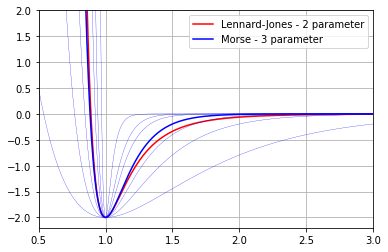

In [3]:
x=np.linspace(0.25,3,1000)
D = 2.0
re= 1.0
k = 2*D*np.square(6/re)   # k-fixed so Morse and LennardJones fit together
a = np.sqrt(k/(2*D))
print('LennardJones potential - depth D and distance re imply a spring constant k')
print('Morse potential        - spring constant k can be selected independently')

plt.plot(x,lennardJones(x, re, D),color='red',label="Lennard-Jones - 2 parameter");
plt.plot(x,morse(x, re, D, a),color='blue',label="Morse - 3 parameter");
for aa in a*np.array([4,2,1.5,0.75,0.5,0.25]):
    plt.plot(x,morse(x, re, D, aa),linewidth=0.25,color='blue');
plt.ylim(-1.1*D,D);
plt.xlim(0.5*re,3*re);
plt.grid(True);
plt.legend();

In [4]:
def potential(spec1, spec2, r):
    re,D,a=1.0,2,2
    return morse(r, re, D, a)

def calcForce(part1,part2,eps = 0.001):
    rVec12 = part1['pos']-part2['pos']
    distance = np.sqrt(np.sum(np.square(rVec12)))   
    
    energy = potential(part1['type'],part2['type'],distance)
    
    potInc = potential(part1['type'],part2['type'],distance + rVec12[0]/distance*eps)
    potDec = potential(part1['type'],part2['type'],distance - rVec12[0]/distance*eps)
    fx = (potInc-potDec)/(2*eps)
    
    potInc = potential(part1['type'],part2['type'],distance + rVec12[1]/distance*eps)
    potDec = potential(part1['type'],part2['type'],distance - rVec12[1]/distance*eps)
    fy = (potInc-potDec)/(2*eps)
    
    potInc = potential(part1['type'],part2['type'],distance + rVec12[2]/distance*eps)
    potDec = potential(part1['type'],part2['type'],distance - rVec12[2]/distance*eps)
    fz = (potInc-potDec)/(2*eps)
    
    fVec = (-1)*np.array([fx,fy,fz]) #F=-grad V
    fabs = np.sqrt(np.sum(np.square(fVec))) 
    return fVec, fabs, energy

def updatePos(pos,fResVec,ds=0.01):
    totForce = 0
    for coord in range(3):
        totForce = totForce + fResVec[coord]*fResVec[coord]
    totForce = np.sqrt(totForce)
    
    for coord in range(3):
        pos[coord] = pos[coord] + fResVec[coord]/totForce*ds
    return pos

def calcCenterOfMass(parts):
    centerOfMass = np.zeros(3)
    mTot = 0
    for p in parts:
        m = massDict[p['type']]
        mTot = mTot+m
        centerOfMass = centerOfMass + p['pos']*m
    return centerOfMass/mTot

def plotPart(parts, figSize = 5):
    fig, ax = plt.subplots()
    x=[p['pos'][0] for p in parts]
    y=[p['pos'][1] for p in parts]
    for p1 in parts:
        for p2 in parts:
            rVec12 = p1['pos']-p2['pos']
            r12 = np.sqrt(np.sum(np.square(rVec12)))
            if 0<r12<1.1:
                plt.plot([p1['pos'][0],p2['pos'][0]],[p1['pos'][1],p2['pos'][1]],color='black')
    plt.plot(x,y,'ro')   #plot particles
    #plt.xlim(-figSize,figSize)
    #plt.ylim(-figSize,figSize)
    ax.set_aspect(1)
    plt.grid(True)
    return

def optimizeGeometry(parts, maxSteps=1000, DS=0.001, energyThresh=0.00001, forceThresh=0.1):
    totEnergyPrev = float("inf")

    for step in range(maxSteps):
        fResVecAll = np.zeros((len(parts),len(parts),3))
        for k, p1 in enumerate(parts[:-1]):
            totEnergy = 0
            totForce = 0
            for p2 in parts[k+1:]:
                #print('      ',p1['id'],p2['id'])
                fVec,fabs,e12 = calcForce(p1,p2)
                fResVecAll[p1['id'],p2['id']]=fVec
                fResVecAll[p2['id'],p1['id']]=-fVec
                totEnergy = totEnergy + e12
                totForce = totForce + fabs
        if step %100 ==0:
            print(step, '  totE: ',totEnergy, abs(totEnergy-totEnergyPrev),totForce)

        if abs(totEnergy-totEnergyPrev) < energyThresh and totForce < forceThresh:
            break
        else:
            totEnergyPrev = totEnergy

        for p1 in parts:
            fResVec = np.zeros(3)
            for p2 in parts:
                fResVec = fResVec + fResVecAll[p1['id'],p2['id'],:]

            if p1['id'] == 0:
                p1['pos'] = p1['pos']
            elif p1['id'] == 1:
                #print(fResVec,np.array([1,0,0]))
                p1['pos'] = updatePos(p1['pos'],fResVec*np.array([1,0,0]), ds=DS)
            else:
                p1['pos'] = updatePos(p1['pos'],fResVec, ds=DS)

    return parts

{'id': 0, 'type': 'O', 'pos': array([0, 0, 0])}
{'id': 1, 'type': 'H', 'pos': array([0.5, 0. , 0. ])}
{'id': 2, 'type': 'H', 'pos': array([0.96524214, 0.01165469, 0.        ])}
{'id': 3, 'type': 'H', 'pos': array([0.73599162, 0.15801272, 0.        ])}
{'id': 4, 'type': 'H', 'pos': array([0.98633945, 0.01688065, 0.        ])}
{'id': 5, 'type': 'H', 'pos': array([0.87949127, 0.68135066, 0.        ])}
{'id': 6, 'type': 'H', 'pos': array([0.85734238, 0.99981623, 0.        ])}
{'id': 7, 'type': 'H', 'pos': array([0.23971518, 0.33807776, 0.        ])}
{'id': 8, 'type': 'H', 'pos': array([0.70819433, 0.28058169, 0.        ])}


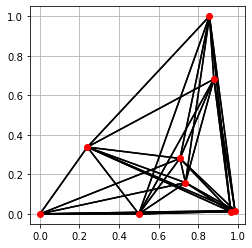

In [5]:
massDict = {'O':16,'H':1}

random.seed(15)
part1 = {'id':0,'type':'O','pos':np.array([0,0,0])}
part2 = {'id':1,'type':'H','pos':np.array([0.5,0,0])}
parts = [part1,part2]
#for k in range(2,7):
for k in range(2,9):
    parts.append({'id':k,'type':'H','pos':np.array([random.random(),random.random(),0])})

for p in parts:
    print(p)
    
plotPart(parts, 2)

0   totE:  5.03036492393583 inf 43.120671864352936


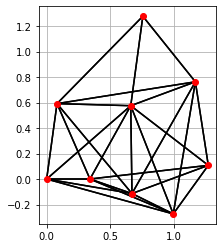

In [6]:
parts = optimizeGeometry(parts,maxSteps=30, DS=0.01, energyThresh = 0.00001, forceThresh = 0.1)
plotPart(parts, figSize = 5)

0   totE:  1.4857709494387836 inf 24.50465713794469
100   totE:  0.19119936395923398 0.028391825534907156 17.138547572127365
200   totE:  -0.9911239787192334 0.01544749856913552 9.717459791717895
300   totE:  -1.603630925523572 0.004176563901497898 5.146944440488345
400   totE:  -1.6856215682440592 0.00798105937406568 4.4293132159463
500   totE:  -1.6795241398297196 0.0065847205967071165 4.484314321148755
600   totE:  -1.7004100214178184 0.00041377679025877967 4.294660243769856
700   totE:  -1.7225583952788228 0.000971360745640748 4.089416752421527
800   totE:  -1.7235358403831003 0.005568136853990602 4.080253543496429
900   totE:  -1.7235302204181187 0.005569625140514622 4.080306254802919


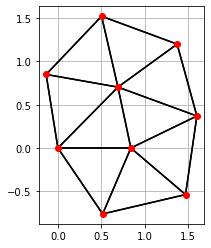

In [7]:
parts = optimizeGeometry(parts,maxSteps=1000, DS=0.001, energyThresh = 0.00001, forceThresh = 0.1)
plotPart(parts, figSize = 5)